In [51]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import requests
import holidays

from pandas import CategoricalDtype
from bs4 import BeautifulSoup
from datetime import date
from prophet import Prophet
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error
from scipy import stats
from prophet.diagnostics import cross_validation, performance_metrics

import sys
import os

backend_path = os.path.abspath('../backend')
sys.path.append(backend_path)
from get_metrics import get_metrics

In [52]:
# чтение DataFrame df в файл data/df.csv
df = pd.read_csv('../data/df.csv')

# чтение DataFrame df_train в файл data/df_train.csv
df_train = pd.read_csv('../data/df_train.csv')

# чтение DataFrame df_test в файл data/df_test.csv
df_test = pd.read_csv('../data/df_test.csv')

In [53]:
df['ds'] = pd.to_datetime(df['ds'], format='%Y-%m-%d', dayfirst=True)
df_train['ds'] = pd.to_datetime(df_train['ds'], format='%Y-%m-%d', dayfirst=True)
df_test['ds'] = pd.to_datetime(df_test['ds'], format='%Y-%m-%d', dayfirst=True)

# Baseline Prophet

In [54]:
# обучение модели baseline prophet
bl_prophet = Prophet()
bl_prophet.fit(df_train)

01:16:06 - cmdstanpy - INFO - Chain [1] start processing
01:16:07 - cmdstanpy - INFO - Chain [1] done processing


In [55]:
future = bl_prophet.make_future_dataframe(periods=365, freq='D')
forecast = bl_prophet.predict(future)
forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
2718,2024-03-07,13.832990,11.226190,16.141352
2719,2024-03-08,13.882275,11.481736,16.477267
2720,2024-03-09,14.698678,12.299558,17.185310
2721,2024-03-10,14.745449,12.255160,17.257220
2722,2024-03-11,13.996327,11.554096,16.487701
2723,2024-03-12,14.039399,11.589640,16.414786
2724,2024-03-13,14.119970,11.711913,16.517858
2725,2024-03-14,14.127607,11.713821,16.727060
2726,2024-03-15,14.145141,11.534455,16.563846
2727,2024-03-16,14.930480,12.501234,17.363050


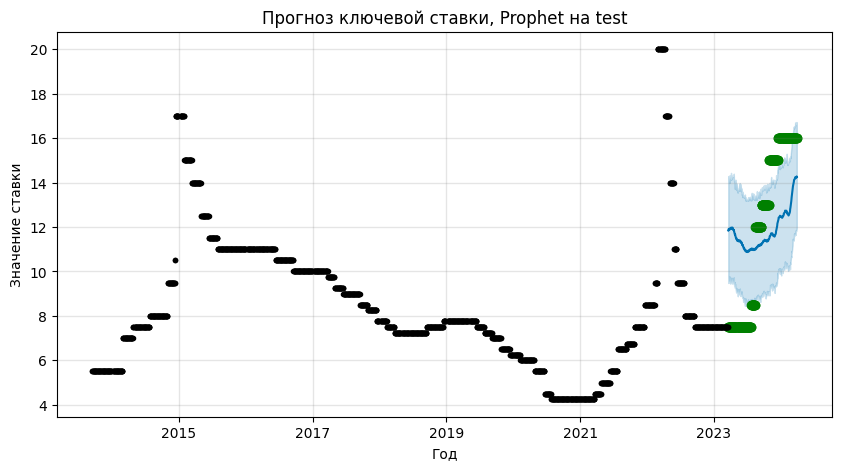

In [56]:
# смотрим совпадение фактического курса с предсказанным курсом baseline prophet
fig, ax = plt.subplots(figsize= (10, 5))

predict = bl_prophet.predict(df_test)
fig = bl_prophet.plot(predict, ax=ax)
ax.scatter(df_test.ds, df_test['y'], color = 'g')
ax.set_title('Прогноз ключевой ставки, Prophet на test')
ax.set_ylabel('Значение ставки')
ax.set_xlabel('Год')
plt.show()

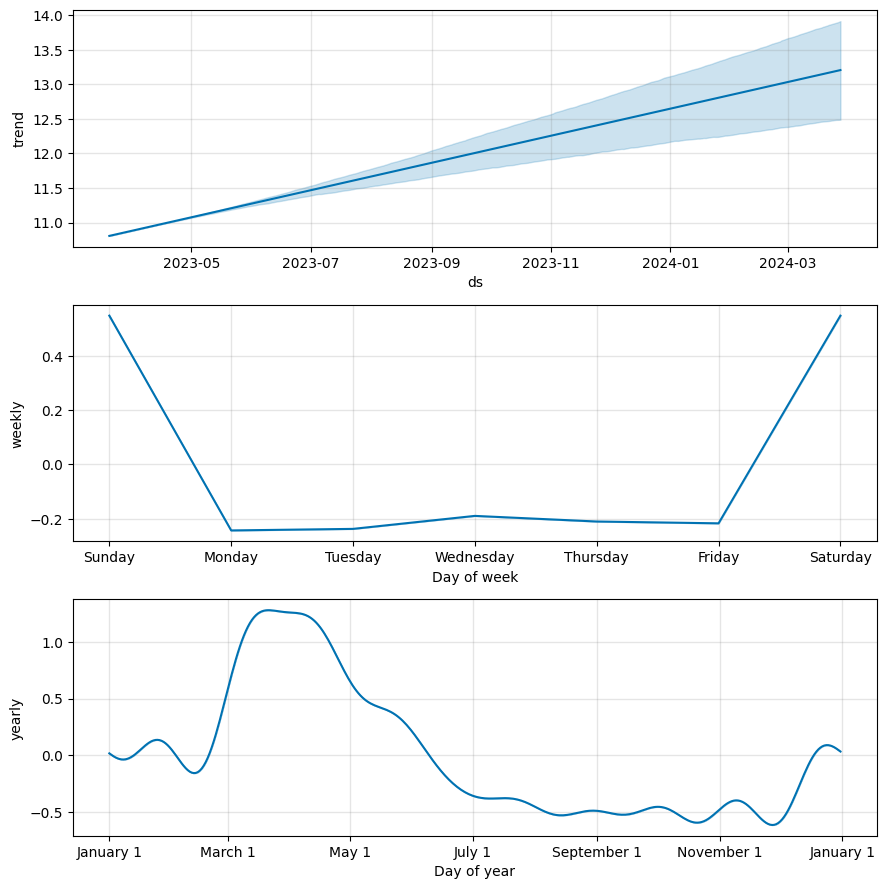

In [57]:
# смотрим тренд, годовые и сезонные признаки
fig = bl_prophet.plot_components(predict)
plt.show()

In [58]:
df_test_forecast = bl_prophet.predict(df_test)
df_test_forecast['ds'] = pd.to_datetime(df_test_forecast['ds'], format='%Y-%m-%d', dayfirst=True)
df_test_forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(10)

,ds,yhat,yhat_lower,yhat_upper
252,2024-03-15,14.145141,11.626816,16.457323
253,2024-03-18,14.170077,11.663830,16.648623
254,2024-03-19,14.187018,11.746852,16.519269
255,2024-03-20,14.243834,11.894002,16.561977
256,2024-03-21,14.230328,11.638254,16.661808
257,2024-03-22,14.229484,11.940869,16.673956
258,2024-03-25,14.216135,11.671357,16.890085
259,2024-03-26,14.225622,11.702673,16.491586
260,2024-03-27,14.277305,11.838379,16.645439
261,2024-03-28,14.260699,11.886034,16.612835


In [59]:
holiday = pd.DataFrame([])
for date, name in sorted(holidays.Russia(years=[2013,2014,2015,2016,2017,2018,2019,2020,2021,2022,2023,2024]).items()):
    new_row = pd.DataFrame({'ds': date, 'holiday': "RU-Holidays"}, index=[0])
    holiday = pd.concat([holiday, new_row], ignore_index=True)

holiday['ds'] = pd.to_datetime(holiday['ds'], format='%Y-%m-%d', errors='ignore')

In [60]:
holiday

,ds,holiday
0,2013-01-01,RU-Holidays
1,2013-01-02,RU-Holidays
2,2013-01-03,RU-Holidays
3,2013-01-04,RU-Holidays
4,2013-01-05,RU-Holidays
...,...,...
165,2024-03-08,RU-Holidays
166,2024-05-01,RU-Holidays
167,2024-05-09,RU-Holidays
168,2024-06-12,RU-Holidays


In [61]:
# выводиим метрики для оценкии baseline prophet 
get_metrics = get_metrics(y_test=df_test['y'], y_pred=predict['yhat'], name='Baseline Prophet')
get_metrics

,model,MAE,MAPE_%,MSE,RMSE
0,Baseline Prophet,2.948808,0.290335,9.783397,3.127842


1. Mean Absolute Error (MAE) - Среднее абсолютное отклонение позволяет оценить среднее абсолютное отклонение прогнозов от фактических значений. Чем ниже MAE, тем лучше модель.
2. Mean Absolute Percentage Error (MAPE) - Среднее абсолютное процентное отклонение показывает средний процент ошибки прогноза от фактических значений. Чем ниже MAPE, тем лучше.
3. Mean Squared Error (MSE) - Среднеквадратичное отклонение предоставляет информацию о среднеквадратичном отклонении прогнозов от фактических значений. Чем ниже MSE, тем лучше модель.
4. Root Mean Squared Error (RMSE) - Квадратный корень из MSE помогает интерпретировать стандартное отклонение прогнозов от фактических значений.

# Tuning Prophet

## Hyperparameter tuning

In [62]:
# период, который надо отрезать и предсказать (проверка модели)
pred_days = int(df.shape[0]*0.1)

In [63]:
# выводиим метрики для оценкии tuning prophet 
#metrics = pd.concat([metrics, get_metrics(y_test=df_cv['y'], y_pred=df_cv['yhat'], name='CV Prophet')])
#metrics